# Herman Franclin Tesso Tassang 

## Header
The notebook is divided into three sections, each representing one exercise of the assignment. Each section includes a short description at the beginning and a brief discussion at the end.

### References:
*  Lecture notes
* [https://en.wikipedia.org/wiki/BLEU](wikipedia (BLEU score)) 
* I used ChatGPT to debug my code.
* [Jason Brownlee’s tutorial](https://machinelearningmastery.com/develop-a-caption-generation-model-in-keras/)

In [ ]:
# dependencies

import numpy as np
import pandas as pd
import  matplotlib.pyplot as plt
import time
import pickle
import cv2
from PIL import Image

from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPool2D, Conv2D,Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam

from keras.losses import CategoricalCrossentropy

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping  # Import EarlyStopping callback

from keras.datasets import cifar10

from tensorflow.keras.utils import to_categorical


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import tensorflow.keras.backend as K

# metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import os
import zipfile

# X, X_val, y, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Load images

In [3]:

# Define the path to the directory containing images
image_dir = '/kaggle/input/image-denoising/lfwcrop_color/faces'

# Initialize an empty list to store the image arrays
image_list = []

# Loop over all files in the directory
for filename in os.listdir(image_dir):
    if filename.endswith('.ppm') or filename.endswith('.png') or filename.endswith('.jpg'):  # Add more extensions if needed
        # Full path to the image file
        img_path = os.path.join(image_dir, filename)

        # Read the image using OpenCV
        img = img = Image.open(img_path)

        # Optionally, resize the image to a consistent size
        #img = cv2.resize(img, (256, 256))  # Resize to 256x256 pixels

        # Append the image array to the list
        image_list.append(img)

# Convert the list of image arrays to a single NumPy array
# The resulting array will have shape (num_images, height, width, num_channels)
data = np.array(image_list)

# Print the shape of the resulting NumPy array
print(f'Loaded {data.shape[0]} images with shape {data.shape[1:]}')


Loaded 13233 images with shape (64, 64, 3)


# 1. Fully convolutional networks for image denoising


## Description of the model architecture:
* Encoder Part: Three convolutional layers (conv1, conv2, conv3) with max pooling layers (pool1, pool2, pool3) are used to downsample the input image.
        

 * Decoder Part: Two transpose convolutional layers (up4, up5) with concatenation layers (merge4, merge5) are used to upsample the feature maps.
   Convolutional layers (conv4, outputs) are applied to reconstruct the denoised image.

        
  * Activation Functions:  ReLU activation is used for all convolutional layers except for the output layer, which uses a sigmoid activation to ensure pixel values are in the       range $[0, 1]$.
       

   * Model Output:  The output of the model is the denoised image.
       
This architecture follows a typical Encoder-Decoder structure for denoising images, where the encoder learns to extract features and the decoder reconstructs the denoised image.


## intution behind the chosen loss : MSE

The primary goal is to minimize the difference between the denoised output produced by the model and the original clean image.

Mean Squared Error (MSE)  is defined as the average of the squared differences between the predicted and actual pixel values.
    Formula:$$MSE=\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y_i})^2$$

   where $\hat{y_i}\ $ is the predicted pixel value and $y_i\ $ is the actual pixel value.
    
  **Intuition:**
  
   * Penalizes Large Errors: Squaring the differences emphasizes larger errors more than smaller ones, making the model more sensitive to outliers.
   * Smoothness: MSE encourages the model to produce smooth and continuous predictions, which is often desirable in image denoising as it helps in removing noise while preserving important details.

### noisy the images / prepare the data for training

In [5]:
def preprocessing(data, sigma=4):

  # normilized the data
  target =data.astype('float32')/255
  #target =data
  # Add noise to the images
  noisy_images= target + sigma*np.random.normal(loc=0, scale=1,size=data.shape)
  #noisy_images=np.clip(noisy_images,0,1)

  #Split the data into training and test set
  X_train, X_test, y_train, y_test = train_test_split(noisy_images, target , test_size=0.2, random_state=42)

  return  X_train, X_test, y_train, y_test

In [64]:
X_train, X_test, y_train, y_test=preprocessing(data, sigma=0.4)

### build the Architecture

In [58]:
class Encoder_Decoder:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.model = self.build_Denoising_model()

    def build_Denoising_model(self):
        inputs = Input(shape=self.input_shape)

        ##########  Encoder part

        ## Down conv1 (convolutional layer)
        conv1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        ## Down conv2 (convolutional layer)
        conv2 = Conv2D(32, 3, activation='relu', padding='same')(pool1)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

        ## Down conv3 (convolutional layer)
        conv3 = Conv2D(64, 3, activation='relu', padding='same')(pool2)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

        ############ Decoder part

        ## Up conv1 (De-convolutional layer)
        up4 = Conv2DTranspose(32, 2, strides=(2, 2), activation='relu', padding='same')(conv3)
        merge4 = concatenate([conv2, up4], axis=-1) #concatenation
        conv4 = Conv2D(32, 3, activation='relu', padding='same')(merge4)

        ## Up conv2 (De-convolutional layer)
        up5 = Conv2DTranspose(16, 2, strides=(2, 2), activation='relu', padding='same')(conv4)
        merge5 = concatenate([conv1, up5], axis=-1) #concatenation
        outputs = Conv2D(3, 3, activation='sigmoid', padding='same')(merge5)

        # define the model
        model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Encoder-Decoder')
        return model


height, width, channels=(64,64,3)
# Compile the model
model = Encoder_Decoder(input_shape=(height, width, channels))
model.model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# model achitecture
model.model.summary()

Model: "Encoder-Decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 64, 64,    │        448 │ input_layer_8[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 32, 32,    │          0 │ conv2d_40[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 32, 32,    │      4,640 │ max_pooling2d_24… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 16, 16,    │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 16, 16,    │     18,496 │ max_pooling2d_25… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_16 │ (None, 32, 32,    │      8,224 │ conv2d_42[0][0]   │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 32, 32,    │          0 │ conv2d_41[0][0],  │
│ (Concatenate)       │ 64)               │            │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 32, 32,    │     18,464 │ concatenate_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_17 │ (None, 64, 64,    │      2,064 │ conv2d_43[0][0]   │
│ (Conv2DTranspose)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 64, 64,    │          0 │ conv2d_40[0][0],  │
│ (Concatenate)       │ 32)               │            │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 64, 64, 3) │        867 │ concatenate_5[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,203 (207.82 KB)

 Trainable params: 53,203 (207.82 KB)

 Non-trainable params: 0 (0.00 B)

### training 

In [59]:

# Train the model
history = model.model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0192 - mae: 0.1021 - val_loss: 0.0037 - val_mae: 0.0466
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0033 - mae: 0.0441 - val_loss: 0.0027 - val_mae: 0.0401
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0026 - mae: 0.0395 - val_loss: 0.0023 - val_mae: 0.0374
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0023 - mae: 0.0373 - val_loss: 0.0022 - val_mae: 0.0362
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0022 - mae: 0.0363 - val_loss: 0.0021 - val_mae: 0.0355
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0021 - mae: 0.0355 - val_loss: 0.0020 - val_mae: 0.0351
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0020 - mae: 0.0349 - val_loss: 0.0019 - val_mae: 0.0341
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0019 - mae: 0.0341 - val_loss: 0.0019 - val_mae: 0.0339
Epoch 9/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/

### model evaluation

In [60]:

# Evaluate the model
loss, mae = model.model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test MAE: {mae}')

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0018 - mae: 0.0328
Test Loss: 0.0018097027204930782, Test MAE: 0.03283020853996277


### Visual inspections

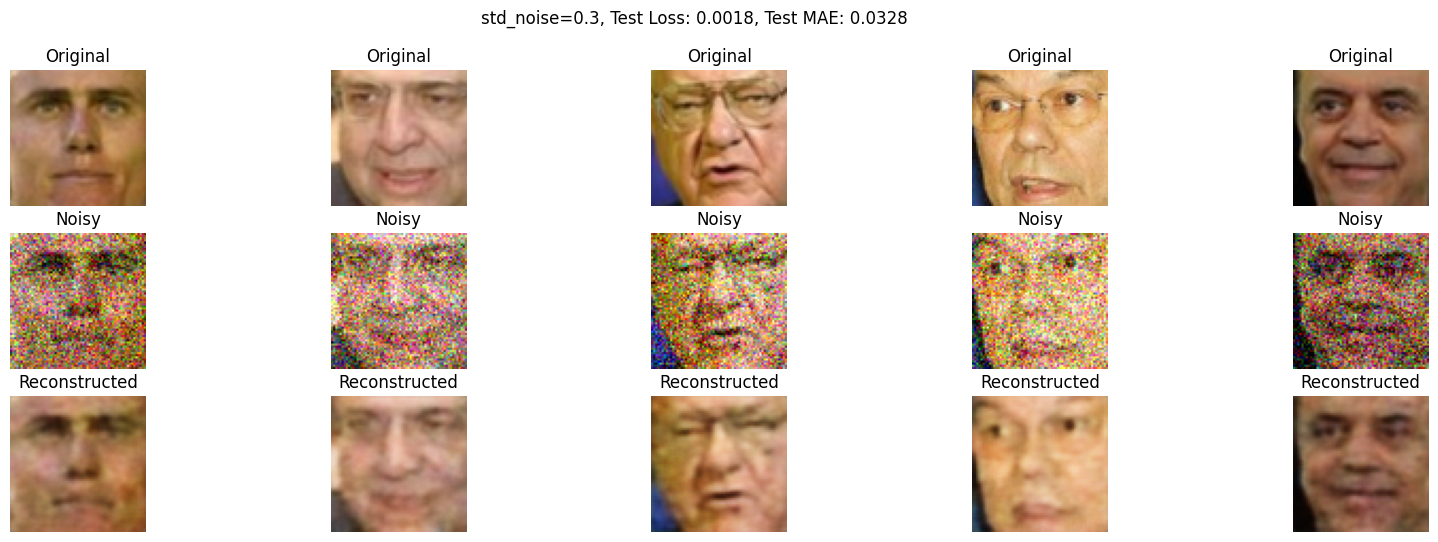

In [62]:
# Predict on the test set

#decoded_imgs = model.model.predict(X_test)

# Display the original, noisy, and reconstructed images

n = 5  # Number of images to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(y_test[i])
    plt.title("Original")
    plt.axis('off')

    # Display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_test[i])
    plt.title("Noisy")
    plt.axis('off')

    # Display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstructed")
    plt.axis('off')
    plt.suptitle('std_noise=0.3, Test Loss: 0.0018, Test MAE: 0.0328')
plt.show()

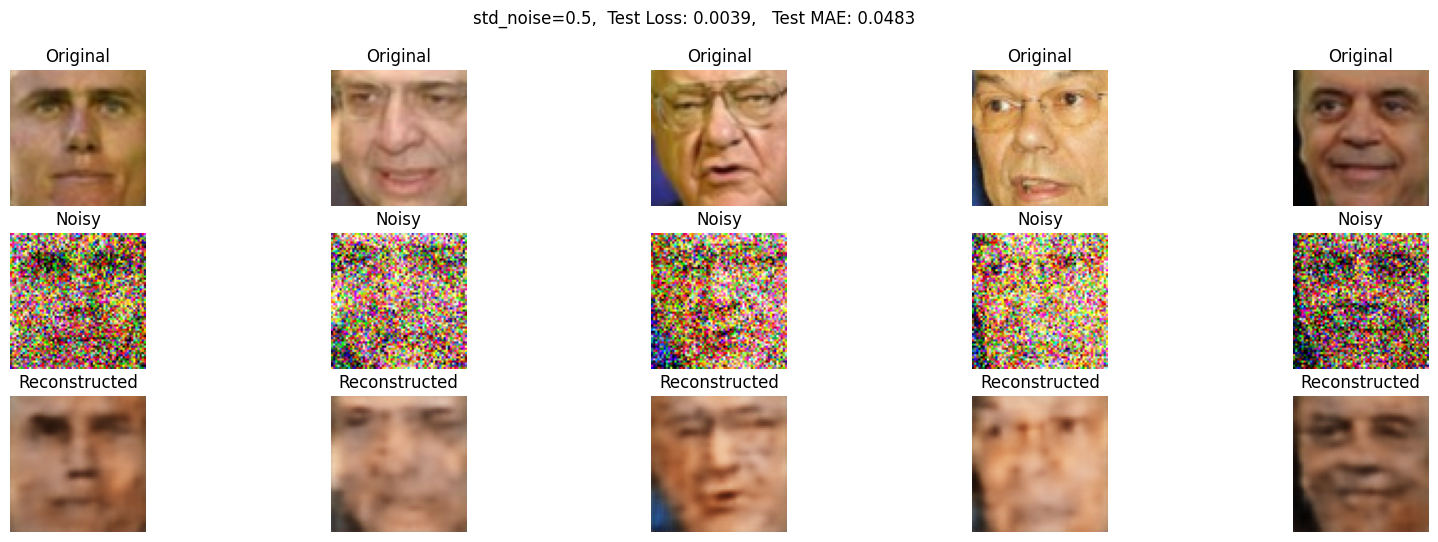

In [76]:

# Predict on the test set

decoded_imgs = model.model.predict(X_test)

# Display the original, noisy, and reconstructed images

n = 5  # Number of images to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(y_test[i])
    plt.title("Original")
    plt.axis('off')

    # Display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_test[i])
    plt.title("Noisy")
    plt.axis('off')

    # Display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstructed")
    plt.axis('off')
    plt.suptitle('std_noise=0.5,  Test Loss: 0.0039,   Test MAE: 0.0483')
plt.show()

 ## Discussion
The architecture that has been constructed shows a relatively acceptable performance. However, this performance is directly influenced by the level of noise present in the data. The presence of more noise makes it increasingly challenging for the model to accurately recognize the image (refer to visual inspections ).

# 2. Training a small image captioning model (Jason Brownlee’s tutorial)

## a) The model uses word2vec. What is word2vec? Where, how, and why is it used in this model?

**Word2Vec** is a technique used in NLP to create dense vector representations, or word embeddings, for words. In this model, it is employed in the sequence processor part of the model to handle text input. Its purpose is to construct a pre-trained word embeddings model to enhance the learning representation of words, rather than learning from scratch. This approach improves the quality and accuracy of generated captions.
## b) A clear description and explanation of the loss function used for training this model.

**Description:**

The loss function utilized in this model is Categorical Cross-Entropy.

Image captioning can be seen as a task of predicting a sequence of words (caption) based on an image. The categorical cross-entropy loss is employed to measure the disparity between the predicted probability distribution of the next word in the sequence and the actual distribution (the true next word). For each word in the sequence, this loss is computed, and the overall loss is the summation of all individual word losses.

**Explanation:**

The reasoning behind incorporating the categorical cross-entropy loss in this model is to train the model to accurately forecast the sequence of words (caption) for a given image. By minimizing the difference between the predicted and true probability distributions for each word in the sequence, the model can improve its prediction capabilities.

## c) 

**What is a BLEU score:**

BLEU, which stands for "*bilingual evaluation understudy*" is a metric for evaluating the quality of text which has been machine-translated from one natural language to another. Qualility here being the correspondence between a machine's output and that of a human.

**how is it calculated?**

The BLUE score here is calculated by comparing the predicted   $\ \hat{y}\ $  description's *n-grams* $G_n(\hat{y})\ $  to refernce descriptions' $S:=  (y^{(1)}, \ldots, y^{(N)}) $ *n-gams* for each images, computing precision for each *n-gram* length (by dividing the number of matching n-gtams by the total number of n-grams in the predicted description) , clipping to handle repetition, computing geometric mean of the n-gram precisions, applying brevity penalty to avoid favoring short translations, and combines these factors into a final score ranging from 0 to 1 : "**weighted geometric mean of all the modified n-gram precisions, multiplied by the brevity penalty**"

$$BLEU_w(\hat{y};S):=BP(\hat{y};S)*\exp \bigg(\sum_{n=1}^{\infty}w_n p_n(\hat{y};S)\bigg)$$.


* Although the BLEU score can quantitatively evaluate the performance of a model, it may not fully capture the overall meaning or context of the descriptions. This is because the BLEU score primarily focuses on measuring n-gram matches. Therefore, I don't believe that it is a sufficient measure for assessing the quality of generated captions.


## 3.Image retrieval for vehicle re-identification

# Description
**Data:**

To begin, we loaded and reshaped all the images to a standardized size of (224,224) since they were of varying dimensions.

**Model architecture:**

We define and build a triplet loss model using a "*pre-trained ResNet50*" as the encoder for embedding images. Below are the big picture of the functions used:

*  Encoder Class:

      *  Utilizes ResNet50, pre-trained on ImageNet, as the base model.
      *  Strips the top layers of ResNet50 and adds Global Average Pooling and Flatten layers to produce a 1D feature vector (embedding) of dimension **2048** for each image.
      * The encoder model is used to transform input images into these embeddings.

* Triplet_Loss Function:

     * Custom loss function designed for triplet networks.
     * Takes three inputs: anchor, positive, and negative embeddings.
        Ensures that the distance between the anchor and positive embeddings is smaller than the distance between the anchor and negative embeddings by a margin (alpha).
     * the labels are used to form the triplet (anchor, positive, negative) images.

* build_model (Triplet Network):

     * Comprises three input layers for anchor, positive, and negative images.
     * Each input is processed through the shared encoder to obtain their respective embeddings.
     * The embeddings are concatenated and used to compute the triplet loss during training.The model is compiled with the Adam optimizer and the custom triplet loss function for 5 epochs.
        


In [12]:
#  Download the zip file
#!wget -O VeRi_dataset.zip 'https://drive.google.com/file/d/1M-t2LBkKa0-J9SlsYZgHNI2MPkhOSmGm'

#  Extract the zip file

# Path to the zip file
zip_file_path = 'VeRi.zip'

# Destination directory
extract_to = 'VeRi_dataset'

# Create the directory if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Extract the contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction complete.")

Extraction complete.


### Load training images and labels (VehicleID)

In [3]:
import xml.etree.ElementTree as ET
import pandas as pd

import os
import cv2
from concurrent.futures import ThreadPoolExecutor


# function to load labels from .xml file

def labels_func(path='VeRi_dataset/VeRi/train_label.xml'):
    # Define the path to your XML file
    xml_file_path = path
    
    # Parse the XML file with explicit encoding
    with open(xml_file_path, 'r', encoding='gb2312') as file:
        xml_data = file.read()

    # Parse the XML data
    root = ET.fromstring(xml_data)

    labels= []
    for item in root.find('Items'):
        labels.append(item.attrib)


    labels_df=pd.DataFrame(labels)
    return labels_df

# function to load images
def import_images(name_list,target_size=(224,224),folder_path='VeRi_dataset/VeRi/image_train'):
    
    # Function to load an image given its filename
    def load_image(filename):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        return img

    
    # Define the path to the directory containing images
    image_dir = folder_path
    # Number of threads to use
    num_threads = 15 # Adjust based on your system's capabilities

    # Initialize an empty list to store the image arrays
    image_list = []

    # List of filenames
    filenames = name_list

    # Use ThreadPoolExecutor to load images concurrently
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        # Map the load_image function to each filename and asynchronously load images
        futures = executor.map(load_image, filenames)

        # Iterate through the results as they become available
        for img in futures:
            image_list.append(cv2.resize(img, target_size))
    return image_list


In [5]:
labels_train=labels_func(path='VeRi_dataset/VeRi/train_label.xml')
image_list=import_images(name_list=list(labels_train['imageName']), folder_path='VeRi_dataset/VeRi/image_train')
labels=labels_train['vehicleID']
print('number of sample (image):',len(image_list))
print('')
labels_train.head(5)

number of sample (image): 37746



,imageName,vehicleID,cameraID,colorID,typeID
0,0001_c001_00016450_0.jpg,0001,c001,1,4
1,0001_c001_00016460_0.jpg,0001,c001,1,4
2,0001_c001_00016470_0.jpg,0001,c001,1,4
3,0001_c001_00016480_0.jpg,0001,c001,1,4
4,0001_c001_00016490_0.jpg,0001,c001,1,4


### Define batch generator for training

In [9]:
#@title (anchor , positive, negative ) batch generator
import numpy as np
import cv2
import tensorflow as tf

def triplet_generator(images_list, labels, batch_size):
    label_to_indices = {label: np.where(labels == label)[0] for label in np.unique(labels)}

    while True:
        anchor_batch = []
        positive_batch = []
        negative_batch = []

        for _ in range(batch_size):
            anchor_label = np.random.choice(labels)
            anchor_idx = np.random.choice(label_to_indices[anchor_label])
            positive_idx = np.random.choice(label_to_indices[anchor_label])

            negative_label = np.random.choice([label for label in np.unique(labels) if label != anchor_label])
            negative_idx = np.random.choice(label_to_indices[negative_label])

            # Resize images to the target size
            anchor_image = images_list[anchor_idx]
            positive_image = images_list[positive_idx]
            negative_image = images_list[negative_idx]

            anchor_batch.append(anchor_image)
            positive_batch.append(positive_image)
            negative_batch.append(negative_image)

        yield (np.array(anchor_batch), np.array(positive_batch), np.array(negative_batch)), np.zeros((batch_size,))


### Model archictecture : feature extractor/ triplet loss / main model 

In [7]:
from tensorflow.keras.applications import ResNet50,VGG16
import tensorflow as tf

# features extractor class (encoder)

class Encoder:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.model = self.build_encoder()
    
    def build_encoder(self):
        base_model = ResNet50(include_top=False, input_shape=self.input_shape, weights='imagenet')
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Flatten()(x)
        model = Model(inputs=base_model.input, outputs=x, name="encoder")
        return model

# define the triplet loss function

def triplet_loss(y_true, y_pred, alpha=0.2):
    anchor, positive, negative = y_pred[:, :2048], y_pred[:, 2048:4096], y_pred[:, 4096:]
    
    # Compute the distance between the anchor and the positive
    positive_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    
    # Compute the distance between the anchor and the negative
    negative_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
    
    # Compute the triplet loss
    basic_loss = positive_dist - negative_dist + alpha
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0))
    
    return loss    

# main model     
def build_model(input_shape):
    encoder = Encoder(input_shape)
    embedding_model = encoder.model

    anchor_input = Input(shape=input_shape, name="anchor_input")
    positive_input = Input(shape=input_shape, name="positive_input")
    negative_input = Input(shape=input_shape, name="negative_input")

    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)

    outputs = tf.keras.layers.concatenate([anchor_embedding, positive_embedding, negative_embedding], axis=-1)

    model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=outputs)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss=triplet_loss)
    return model

input_shape = (224, 224, 3)  # input shape here
resn_model = build_model(input_shape) # create an instance of the main model 
print('')
print('model summary:')
print('')
resn_model.summary()


model summary:



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ anchor_input        │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positive_input      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negative_input      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 2048)      │ 23,587,712 │ anchor_input[0][… │
│ (Functional)        │                   │            │ positive_input[0… │
│                     │                   │            │ negative_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 6144)      │          0 │ encoder[0][0],    │
│ (Concatenate)       │                   │            │ encoder[1][0],    │
│                     │                   │            │ encoder[2][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

### Prepare the data for training 

In [11]:

from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(image_list, labels, test_size=0.2, stratify=labels)

# Create generator instances for training and validation sets
target_size=(224,224)
batch_size = 64
train_generator = triplet_generator(X_train, y_train, batch_size)
val_generator = triplet_generator(X_val, y_val, batch_size)

### Training

In [12]:
#@title training
# Train the model using the generators
# Train the model using the generators
history=resn_model.fit(train_generator,
                  epochs=4,
                  steps_per_epoch=len(X_train) // batch_size,
                  validation_data=val_generator,
                  validation_steps=len(X_val) // batch_size)

Epoch 1/4


I0000 00:00:1717138000.426877     137 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


471/471 ━━━━━━━━━━━━━━━━━━━━ 1377s 3s/step - loss: 6.6475 - val_loss: 0.0513
Epoch 2/4
471/471 ━━━━━━━━━━━━━━━━━━━━ 1229s 3s/step - loss: 0.0194 - val_loss: 0.0415
Epoch 3/4
471/471 ━━━━━━━━━━━━━━━━━━━━ 1232s 3s/step - loss: 0.0151 - val_loss: 0.1047
Epoch 4/4
471/471 ━━━━━━━━━━━━━━━━━━━━ 1244s 3s/step - loss: 0.0123 - val_loss: 0.0463


### Load test images and query images with their labels

In [8]:
# function to read .txt file
def read_txt(file_path = 'VeRi_dataset/VeRi/name_query.txt'):
    # Read the file and store each line as an element in a list
    with open(file_path, 'r') as file:
        lines = file.readlines()
    # Remove the newline characters from each line
    names= [line.strip()  for line in lines]
    ID=[line.strip()[:4]  for line in lines]
    # Print the list to verify its contents
    return names,ID

labels_test=labels_func(path='VeRi_dataset/VeRi/test_label.xml')
test_labels=labels_test['vehicleID']
test_images=import_images(name_list=list(labels_test['imageName']), folder_path='VeRi_dataset/VeRi/image_test')
print('number of test images:', len(test_images))
print('')
query_names,query_labels=read_txt(file_path = 'VeRi_dataset/VeRi/name_query.txt')

query_images=import_images(name_list=query_names, folder_path='VeRi_dataset/VeRi/image_query')
print('number of query images:',len(query_images))

number of test images: 11579

number of query images: 1678


### Extract the 'encoder' layer of the trained model to make embeddings prediction for images.

In [10]:
# extract the encoder model
embedd_model= resn_model.get_layer('encoder')

def get_embeddings(images, batch_size=32):
    # Convert images list to numpy array 
    images = np.array(images)
    # Generate embeddings using batch processing
    embeddings = embedd_model.predict(images, batch_size=batch_size)
    return embeddings

# convert test/query images to feature vectors
test_embeddings=get_embeddings(test_images)
query_embeddings=get_embeddings(query_images)

print('test embeddings shape:',(11579,2048))
print('')
print('query embeddings shape:',(1678,2048))

test embeddings shape: (11579, 2048)

query embeddings shape: (1678, 2048)


### Compute mean average precision (mAP) over the full query set.

In [27]:
from sklearn.metrics import pairwise_distances

# Compute Pairwise Distances
dist_matrix = pairwise_distances(query_embeddings, test_embeddings, metric='euclidean')

# Sort and Rank
indices = np.argsort(dist_matrix, axis=1)

# Compute Precision and Average Precision at k=5 (over the top 5 ranked images)
def compute_ap(ranks, relevant, k=5):
    hits = 0
    sum_prec = 0
    for i, r in enumerate(ranks[:k]):  # Only consider top k ranks
        if r in relevant:
            hits += 1
            sum_prec += hits / (i + 1)
    return sum_prec / min(len(relevant), k) if relevant.size else 0

average_precisions = []

for i in range(query_embeddings.shape[0]):
    relevant = np.where(test_labels == query_labels[i])[0]
    ranks = indices[i, :]
    ap = compute_ap(ranks, relevant, k=5)
    average_precisions.append(ap)

# Step 5: Compute Mean Average Precision
mean_ap = np.mean(average_precisions)
print(f"Mean Average Precision (mAP) for top 5: {mean_ap}")


Mean Average Precision (mAP) for top 5: 0.6823400874056417


### Visual inspection of the top 5 rankings for 5 query images.

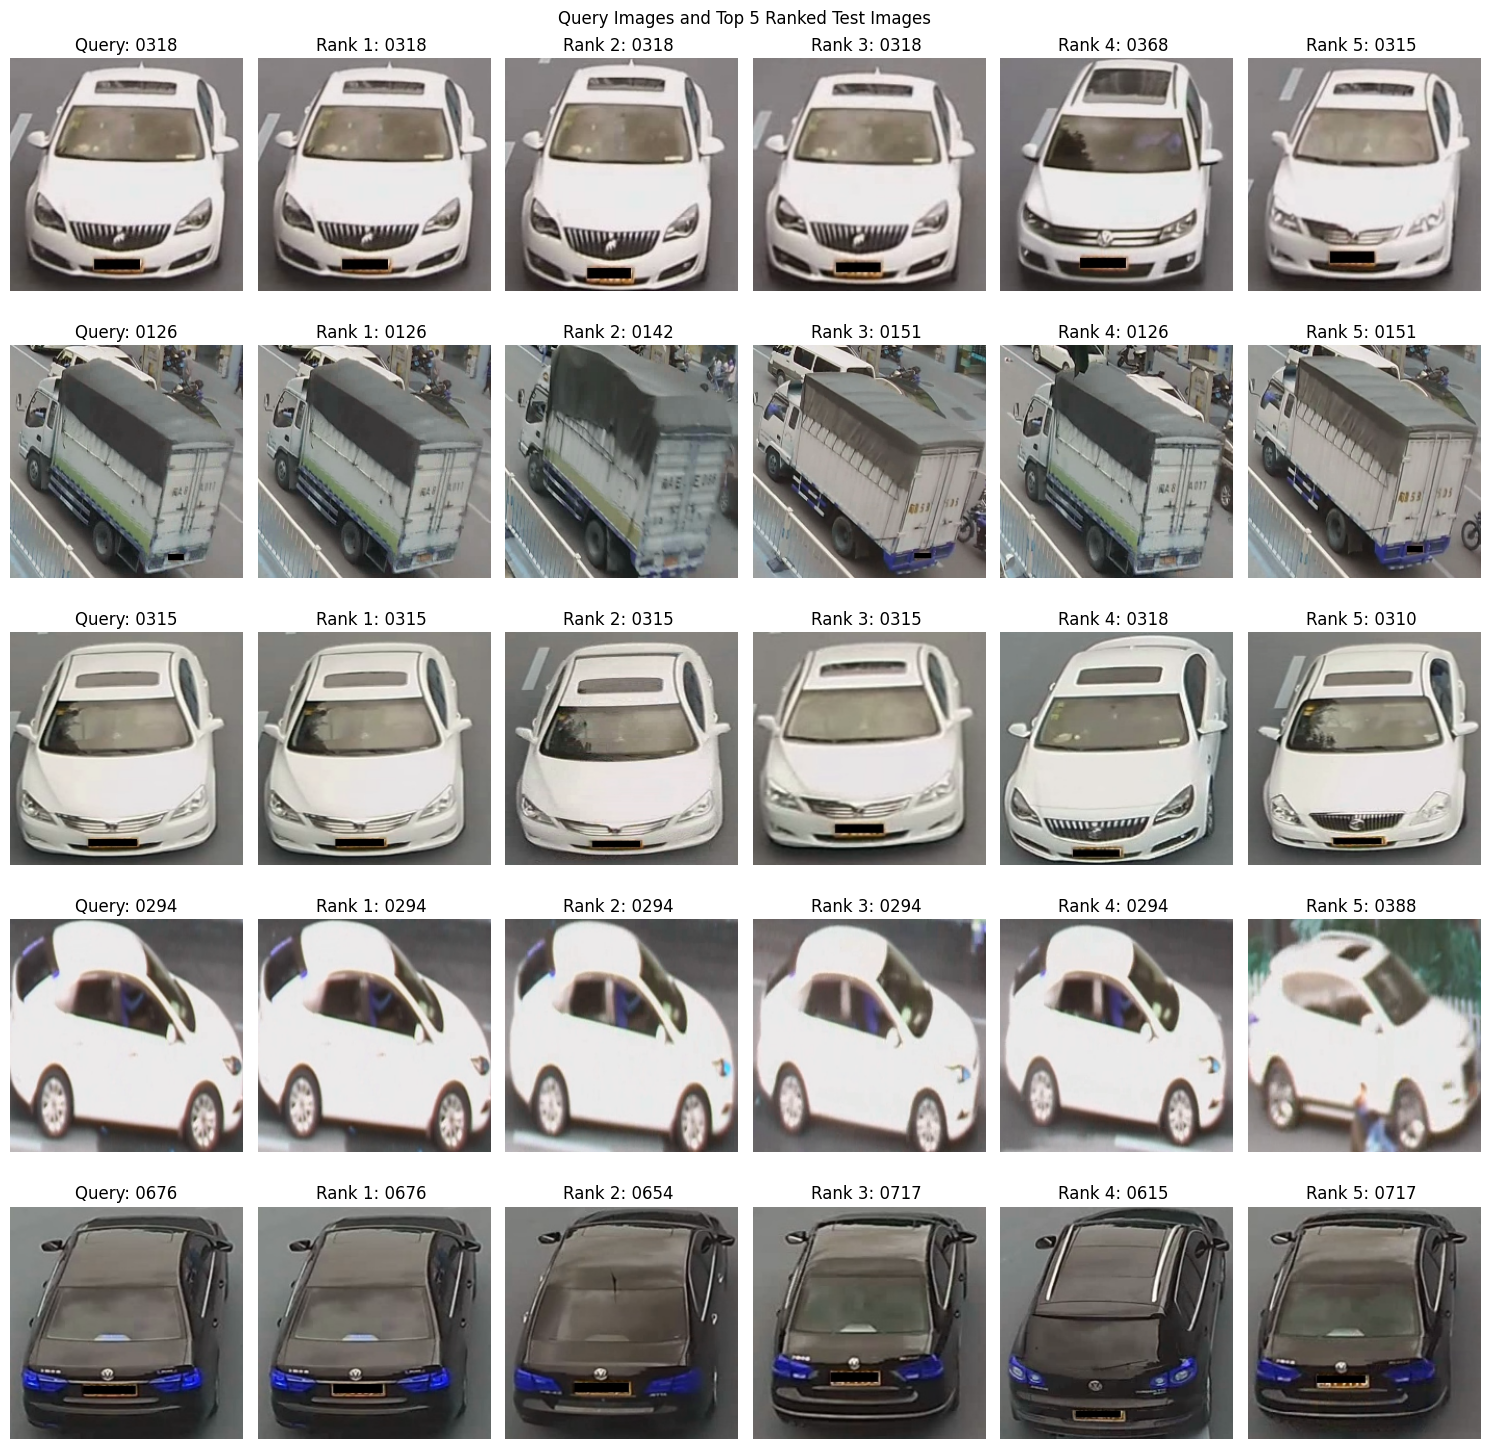

In [30]:
import random
from sklearn.metrics import pairwise_distances
#dist_matrix = pairwise_distances(query_embeddings, test_embeddings, metric='euclidean')
#indices = np.argsort(dist_matrix, axis=1)

# Step 4: Select Random Query Images
random_indices = random.sample(range(len(query_images)), 5)

# Step 5: Plot Results
fig, axs = plt.subplots(5, 6, figsize=(15, 15))
fig.suptitle('Query Images and Top 5 Ranked Test Images')

for i, query_idx in enumerate(random_indices):
    # Plot the query image
    axs[i, 0].imshow(query_images[query_idx])
    axs[i, 0].set_title('Query: {}'.format(query_labels[query_idx]))
    axs[i, 0].axis('off')

    # Plot the top 5 ranked test images
    for j in range(5):
        test_idx = indices[query_idx, j]
        axs[i, j + 1].imshow(test_images[test_idx])
        axs[i, j + 1].set_title('Rank {}: {} '.format(j+1,test_labels[test_idx]))
        axs[i, j + 1].axis('off')

plt.tight_layout()
plt.show()

## Observations

The model took a very long time to train, approximately 20 minutes per epoch.

Once trained, I extracted the encoder layer of the model to transform any image into an embedding vector. These embeddings were used to retrieve similar images from the query database by comparing the distances between each query embedding and all test image embeddings. I obtained an overall mAP of 0.68 for the top 5 rankings over the entire query set.

## Discussion

The model's reliability in terms of **mAP** is not quite consistent. However, I believe that the performance directly depends on the ranking being considered:

If we consider a low ranking level, such as the top 3 rankings, we will have a relatively high mAP. On the other hand, if we consider a higher ranking level (e.g top 10 rankings), it may introduce false positives and result in a lower **mAP**.